In [2]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image
import seaborn as sns

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Block Numa warning

In [5]:
#input_folder = "/kaggle/input/"
dataset_folder = "/kaggle/input/eurosat-dataset/EuroSAT/"

In [6]:
column_names =  ["id", "path", "class_id", "class_name"]

training_df = pd.read_csv(dataset_folder + "train.csv", names=column_names)
validation_df = pd.read_csv(dataset_folder + "validation.csv", names=column_names)
test_df = pd.read_csv(dataset_folder + "test.csv", names=column_names)

In [7]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


In [8]:
rescaling_factor = 1. / 255

In [9]:
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

In [10]:
image_width = 224
image_height = 224

In [11]:
batch_size = 128

In [12]:
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


In [13]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


In [14]:
figure_height = 3
figure_width = 3
figure_size = (14, 14)

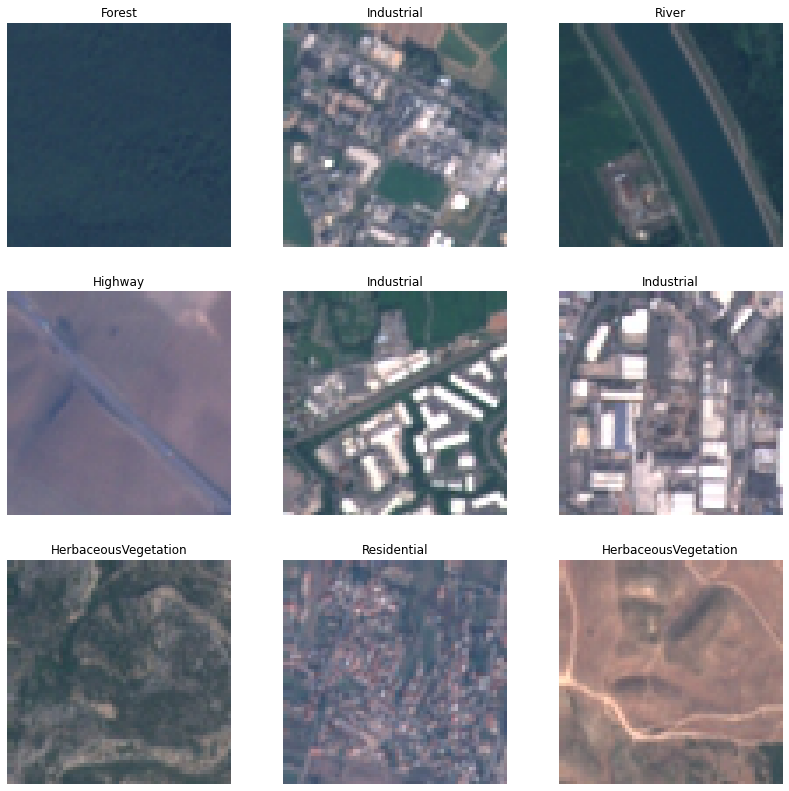

In [49]:
images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

In [15]:
#base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

94781440/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [16]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 74,973,578
Trainable params: 74,920,458
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
model_path = "/kaggle/working/models/eurosat_rgb_model_v1.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [18]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [19]:
history = model.fit(
    training_set,
    validation_data=training_set,
    callbacks=callback_list,
    epochs=1,
    verbose=1,
)

148/148 [==============================] - 5485s 37s/step - loss: 0.4138 - accuracy: 0.9053 - val_loss: 48.0431 - val_accuracy: 0.1103


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


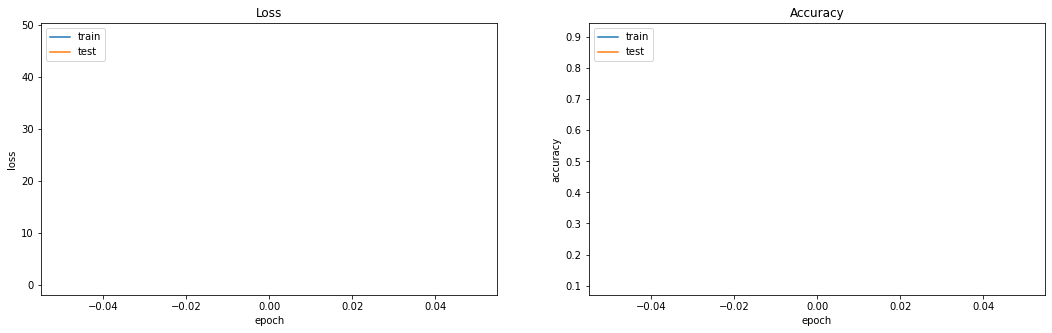

In [20]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

In [21]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [22]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

AlexNet

In [58]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',input_shape = (224, 224, 3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(class_count, activation='softmax'))

learning_rate = 0.001

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 222, 222, 16)      64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 220, 220, 16)      2320      
_________________________________________________________________
batch_normalization_5 (Batch (None, 220, 220, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 108, 32)     

In [59]:
model_path = "/kaggle/working/models/eurosat_rgb_model_v2.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [60]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=1,
    verbose=1,
)

148/148 [==============================] - 585s 4s/step - loss: 3.8278 - accuracy: 0.3621 - val_loss: 146.0212 - val_accuracy: 0.1111


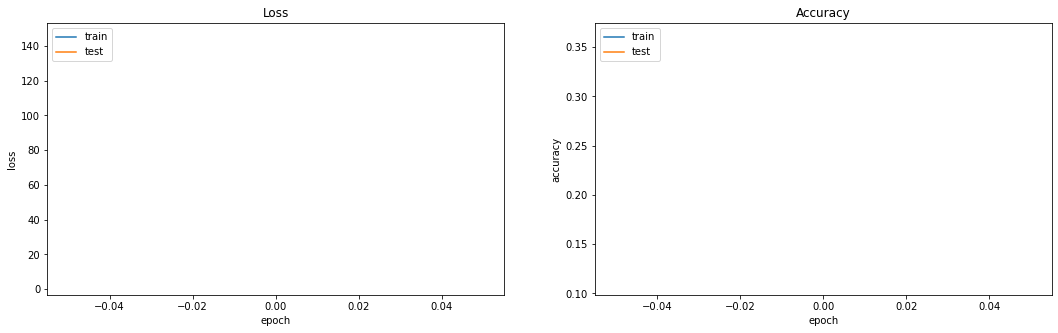

In [61]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

ResNet101

In [62]:
from tensorflow.keras.applications import ResNet101V2

In [63]:
base_model = ResNet101V2(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [64]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 100352)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dense_16 (Dense)             (None, 10)                5130      
Total params: 94,012,426
Trainable params: 93,914,762
Non-trainable params: 97,664
_________________________________________________________________


In [65]:
model_path = "/kaggle/working/models/eurosat_rgb_model_v4.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [66]:
model_path = "/kaggle/working/models/eurosat_rgb_model_v3.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [67]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [68]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=1,
    verbose=1,
)

148/148 [==============================] - 9020s 61s/step - loss: 0.3848 - accuracy: 0.8943 - val_loss: 0.3859 - val_accuracy: 0.8852


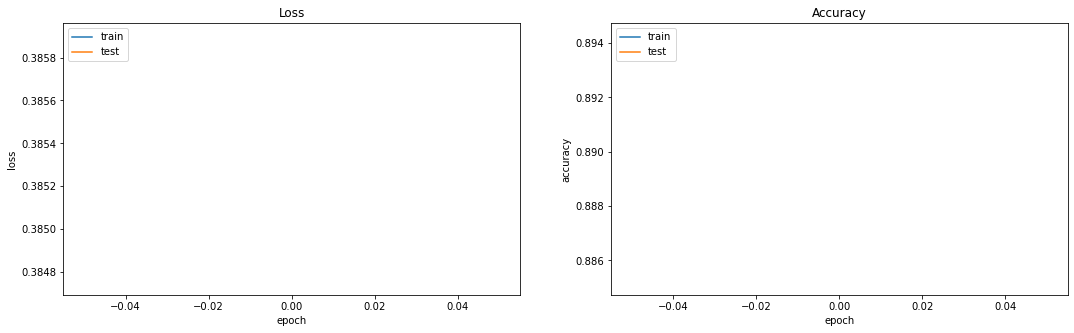

In [69]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

VGG

In [23]:
base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [71]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_18 (Dense)             (None, 10)                5130      
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [25]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=1,
    verbose=1,
)

148/148 [==============================] - 4719s 32s/step - loss: 0.1107 - accuracy: 0.9704 - val_loss: 1703.2402 - val_accuracy: 0.1111


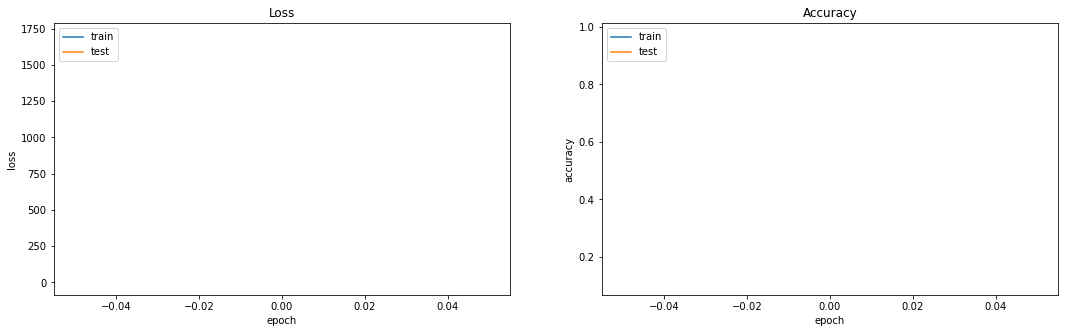

In [26]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()

ZFNet

In [27]:
import tensorflow as tf
model = tf.keras.models.Sequential([
                                    
		tf.keras.layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu',
			input_shape=(224,224, 3)),
		tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),

		tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), activation='relu'),
		tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Lambda(lambda x: tf.image.per_image_standardization(x)),

		tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

		tf.keras.layers.Conv2D(384, (3, 3), activation='relu'),

		tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),

		tf.keras.layers.MaxPooling2D(3, strides=2),

    tf.keras.layers.Flatten(),

		tf.keras.layers.Dense(4096),

		tf.keras.layers.Dense(4096),

		tf.keras.layers.Dense(10 , activation='softmax')
	])


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 109, 109, 96)      14208     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 96)        0         
_________________________________________________________________
lambda (Lambda)              (None, 54, 54, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 384)      

In [30]:
model_path = "/kaggle/working/models/eurosat_rgb_model_v6.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [31]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [32]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=1,
    verbose=1,
)

148/148 [==============================] - 906s 6s/step - loss: 1.3565 - accuracy: 0.4956 - val_loss: 0.9716 - val_accuracy: 0.6296


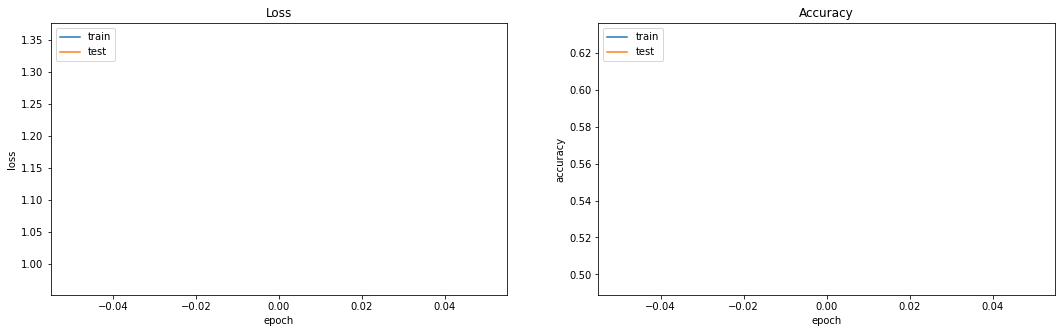

In [33]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

plt.show()